In [56]:
## The purpose of this notebook will be to use correlation matrices from each of the five sgRNA level maps to attempt
## to quantify differences in clustering fidelity, reasoning and high correlation in GI signature between sgRNAs
## targeting the same gene is a good metric for clustering quality control

In [1]:
## Import packages
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from sklearn import metrics
from scipy.stats import gaussian_kde

In [2]:
## Import data

dmso1_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso1_sgmap.xlsx',index_col=0)
atr_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/atr_sgmap.xlsx',index_col=0)
dmso2_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso2_sgmap.xlsx',index_col=0)
etop_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/etop_sgmap.xlsx',index_col=0)
keto_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/keto_sgmap.xlsx',index_col=0)


## Import single sgRNA-Gene table
single_table = pd.read_excel('/Users/benh/Desktop/GI_data/singles_tables/singles_table.xlsx',index_col=0)

dmso1_sgmap = dmso1_sgmap.fillna(0)
atr_sgmap = atr_sgmap.fillna(0)
dmso2_sgmap = dmso2_sgmap.fillna(0)
etop_sgmap = etop_sgmap.fillna(0)
keto_sgmap = keto_sgmap.fillna(0)


In [3]:
## define the function "same_gene_corr" that takes a correlation matrix and returns the average correlation between
## pairs sgRNAs that target the same gene

def same_gene_corr(corr_map):
    pair_list = []
    score_list = []
    for i in range(len(corr_map.index)):
        g1 = corr_map.index[i].split('_')[0]
        for j in range(i+1,len(corr_map.index)):
            g2 = corr_map.index[j].split('_')[0]
            if g1 == 'non-targeting':
                continue
            if g1 == g2:
                pair_list.append(g1)
                score_list.append(corr_map.iloc[i,j])
    return score_list


##Import Max's handy upperTriangle function to avoid counting AB BA GIs twice
def upperTriangle(matrix, k=1):
    keep = np.triu(np.ones(matrix.shape), k=k).astype('bool').reshape(matrix.size)
    return matrix.stack(dropna=False).loc[keep]

In [4]:
## Find intersection between sgRNAs in all maps and slice all maps using this index

intersect = list(set(dmso2_sgmap.index).intersection(etop_sgmap.index).intersection(keto_sgmap.index).intersection(dmso1_sgmap.index).intersection(atr_sgmap.index))

dmso1_sgmap = dmso1_sgmap.loc[intersect,intersect]
atr_sgmap = atr_sgmap.loc[intersect,intersect]

dmso2_sgmap = dmso2_sgmap.loc[intersect,intersect]
etop_sgmap = etop_sgmap.loc[intersect,intersect]
keto_sgmap = keto_sgmap.loc[intersect,intersect]



In [5]:
## Make a consensus matrix by first normalizing each map by its standard deviation, then concatenating all five on the
## same axis, we will concat rows, as this plays nicer with the ".corr" tool in pandas

dmso2_sg_norm = dmso2_sgmap/dmso2_sgmap.values.std()
etop_sg_norm = etop_sgmap/etop_sgmap.values.std()
keto_sg_norm = keto_sgmap/keto_sgmap.values.std()

dmso1_sg_norm = dmso1_sgmap/dmso1_sgmap.values.std()
atr_sg_norm = atr_sgmap/atr_sgmap.values.std()

concat_sgmap = pd.concat((dmso2_sg_norm,etop_sg_norm,keto_sg_norm,dmso1_sg_norm,atr_sg_norm),axis=0)

In [6]:
## Make pearson correlation matrices for each map

dmso2_corr = dmso2_sgmap.corr('pearson')
etop_corr = etop_sgmap.corr('pearson')
keto_corr = keto_sgmap.corr('pearson')

dmso1_corr = dmso1_sgmap.corr('pearson')
atr_corr = atr_sgmap.corr('pearson')

concat_corr = concat_sgmap.corr('pearson')

In [7]:
## Calculate same-gene sgRNA correlation distributions for each map

dmso2_sg_corr = same_gene_corr(dmso2_corr)
etop_sg_corr = same_gene_corr(etop_corr)
keto_sg_corr = same_gene_corr(keto_corr)

dmso1_sg_corr = same_gene_corr(dmso1_corr)
atr_sg_corr = same_gene_corr(atr_corr)

concat_sg_corr = same_gene_corr(concat_corr)


In [157]:
print(np.mean(dmso2_sg_corr),np.mean(etop_sg_corr),np.mean(keto_sg_corr),np.mean(dmso1_sg_corr),np.mean(atr_sg_corr),np.mean(concat_sg_corr))


0.39706848151976754 0.43931849104957005 0.3454124319343787 0.3935671983986562 0.5193743839790527 0.43039078585636625


In [28]:
print(np.mean(upperTriangle(atr_corr).values),np.mean(atr_sg_corr))

0.07102980452000023 0.5193743839790527


In [8]:
index_vector = []
dmso1_vector = []
atr_vector = []
dmso2_vector = []
etop_vector = []
keto_vector = []
consensus_vector = []
pair_vector = []

for i in range(len(dmso1_corr)):
    g1 = dmso1_corr.index[i].split('_')[0]
    for j in range(i+1,len(dmso1_corr)):
        g2 = dmso1_corr.index[j].split('_')[0]
        index_vector.append(dmso1_corr.index[i]+':'+dmso1_corr.index[j])
        dmso1_vector.append(dmso1_corr.iloc[i,j])
        atr_vector.append(atr_corr.iloc[i,j])
        dmso2_vector.append(dmso2_corr.iloc[i,j])
        etop_vector.append(etop_corr.iloc[i,j])
        keto_vector.append(keto_corr.iloc[i,j])
        consensus_vector.append(concat_corr.iloc[i,j])
        if g1 == g2:
            pair_vector.append('same')
        if g1 != g2:
            pair_vector.append('different')
        
        

In [10]:
corr_matrix = pd.DataFrame(index = index_vector)
corr_matrix['dmso1'] = dmso1_vector
corr_matrix['atr'] = atr_vector
corr_matrix['dmso2'] = dmso2_vector
corr_matrix['etop'] = etop_vector
corr_matrix['keto'] = keto_vector
corr_matrix['consensus'] = consensus_vector
corr_matrix['same_gene'] = pair_vector

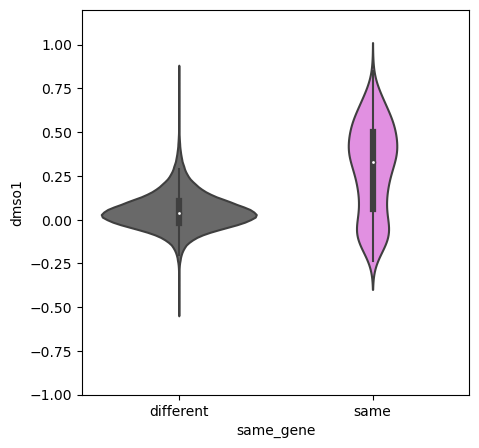

In [16]:
plt.figure(figsize=(5,5))
plt.ylim(-1,1.2)
sns.violinplot(data=corr_matrix,x='same_gene',y='dmso1',scale = 'area',palette=('dimgray','violet'))
plt.savefig('/Users/benh/Desktop/for_figs/dmso1_sgrna_dis.png',dpi=300)

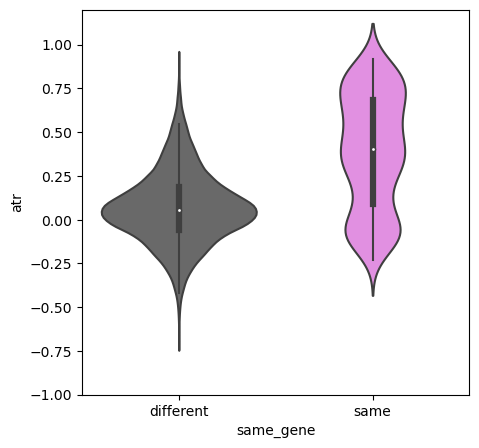

In [15]:
plt.figure(figsize=(5,5))
plt.ylim(-1,1.2)
sns.violinplot(data=corr_matrix,x='same_gene',y='atr',scale = 'area',palette=('dimgray','violet'))
plt.savefig('/Users/benh/Desktop/for_figs/atr_sgrna_dis.png',dpi=300)

<Axes: xlabel='same_gene', ylabel='atr'>

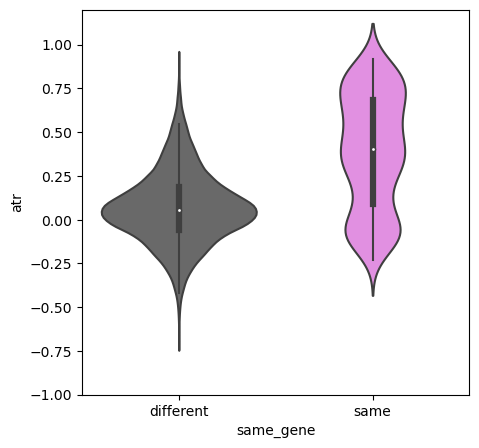

In [28]:
plt.figure(figsize=(5,5))
plt.ylim(-1,1.2)
sns.violinplot(data=corr_matrix,x='same_gene',y='atr',scale = 'area',palette=('dimgray','violet'))
#plt.savefig('/Users/benh/Desktop/for_figs/atr_sgrna_dis.png',dpi=300)

In [22]:
corr_matrix

,dmso1,atr,dmso2,etop,keto,consensus,same_gene
MTRF1L_+_153323797.23-P1P2:STAT5B_+_40427941.23-P1P2,0.092500,0.356646,0.043019,0.110762,-0.117794,0.089477,different
MTRF1L_+_153323797.23-P1P2:CDK1_-_62538382.23-P1P2,0.097410,0.504674,-0.103812,0.051286,0.000386,0.166563,different
MTRF1L_+_153323797.23-P1P2:KIAA1429_+_95565668.23-P1P2,0.143289,0.137840,0.019033,0.187202,-0.036039,0.088930,different
MTRF1L_+_153323797.23-P1P2:ZC3H4_-_47615472.23-P1,0.107833,0.331225,0.093700,0.162340,-0.074181,0.143113,different
MTRF1L_+_153323797.23-P1P2:ENO1_+_8938348.23-P1P2,-0.130194,-0.050373,-0.108178,0.003244,-0.059382,-0.070036,different
...,...,...,...,...,...,...,...
FASTKD2_-_207630388.23-P1P2:ATP5I_-_668026.23-P1P2,0.044360,0.412195,0.106459,0.179257,0.007225,0.118507,different
FASTKD2_-_207630388.23-P1P2:BOLA3_+_74374821.23-P1P2,0.294990,0.334632,0.280417,0.303285,-0.018962,0.207727,different
MOB4_-_198381236.23-P1P2:ATP5I_-_668026.23-P1P2,0.272414,-0.032584,0.160435,0.086710,-0.002900,0.097823,different
MOB4_-_198381236.23-P1P2:BOLA3_+_74374821.23-P1P2,0.060043,0.070030,0.059548,0.161463,-0.086235,0.040210,different


In [47]:
corr_matrix.loc[corr_matrix.loc[corr_matrix['same_gene'] == 'same'].index,'consensus'].median()

0.3667576857271996

In [158]:
dmso_di_corr = dmso1_corr - dmso2_corr
atr_di_corr = atr_corr - dmso1_corr
etop_di_corr = etop_corr - dmso2_corr
keto_di_corr = keto_corr - dmso2_corr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


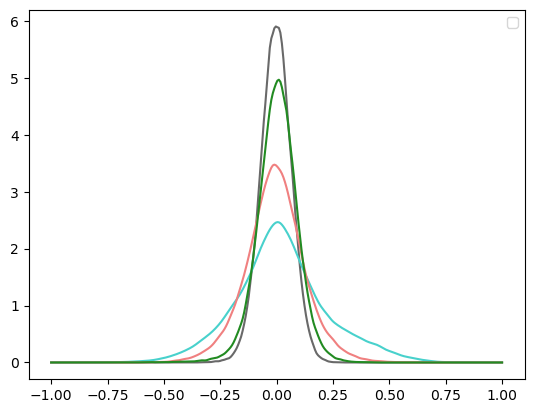

In [159]:
den1 = gaussian_kde(upperTriangle(dmso_di_corr))
den2 = gaussian_kde(upperTriangle(atr_di_corr))
den3 = gaussian_kde(upperTriangle(etop_di_corr))
den4 = gaussian_kde(upperTriangle(keto_di_corr))

xs = np.linspace(-1,1,300)

plt.plot(xs,den1(xs),color = 'dimgray')
plt.plot(xs,den2(xs),color = 'mediumturquoise')
plt.plot(xs,den3(xs),color = 'lightcoral')
plt.plot(xs,den4(xs),color = 'forestgreen')

#plt.legend()